In [18]:
import gym
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

In [19]:
import pybullet_envs

In [20]:
env=gym.make('HalfCheetahBulletEnv-v0')

In [21]:
env.action_space

Box(6,)

In [22]:
num_states = env.observation_space.shape[0]
print("Size of State Space ->  {}".format(num_states))
num_actions = env.action_space.shape[0]
print("Size of Action Space ->  {}".format(num_actions))

upper_bound = env.action_space.high[0]
lower_bound = env.action_space.low[0]

print("Max Value of Action ->  {}".format(upper_bound))
print("Min Value of Action ->  {}".format(lower_bound))

Size of State Space ->  26
Size of Action Space ->  6
Max Value of Action ->  1.0
Min Value of Action ->  -1.0


In [23]:
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process.
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        # Store x into x_prev
        # Makes next noise dependent on current one
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)

In [24]:
class Buffer:
    def __init__(self, buffer_capacity, batch_size):
        self.buffer_capacity = buffer_capacity
        self.batch_size = batch_size

        self.buffer_counter = 0

        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))


    def record(self, obs_tuple):
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1

    def update(self, state_batch, action_batch, reward_batch, next_state_batch,):
        with tf.GradientTape() as tape:
            target_actions = target_actor(next_state_batch, training=True)
            
            
            y = reward_batch + gamma * target_critic([next_state_batch, target_actions], training=True)
            critic_value = critic_model([state_batch, action_batch], training=True)
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )

        with tf.GradientTape() as tape:
            actions = actor_model(state_batch, training=True)
            critic_value = critic_model([state_batch, actions], training=True)
            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )

    def learn(self):

        record_range = min(self.buffer_counter, self.buffer_capacity)

        batch_indices = np.random.choice(record_range, self.batch_size)

        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])
        


        self.update(state_batch, action_batch, reward_batch, next_state_batch)

In [25]:
@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))

In [26]:
def get_actor():
    last_init=tf.random_uniform_initializer(minval=-0.003,maxval=0.003)
    i=layers.Input(shape=(num_states))
    x=layers.Dense(128,activation='relu',autocast=False)(i)
    x=layers.Dense(256,activation='relu')(x)
    x=layers.Dense(256,activation='relu')(x)
    x=layers.Dense(num_actions,activation='tanh',kernel_initializer=last_init)(x)
    x=x*upper_bound
    model=tf.keras.Model(i,x)
    return model

In [27]:
actor=get_actor()

In [28]:
actor.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 26)]              0         
_________________________________________________________________
dense_26 (Dense)             (None, 128)               3456      
_________________________________________________________________
dense_27 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_28 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_29 (Dense)             (None, 6)                 1542      
_________________________________________________________________
tf_op_layer_mul_3 (TensorFlo [(None, 6)]               0         
Total params: 103,814
Trainable params: 103,814
Non-trainable params: 0
_____________________________________________________

In [29]:
def get_critic():
    state_input=layers.Input(shape=(num_states))
    state_output=layers.Dense(16,activation='relu',autocast=False)(state_input)
    state_output=layers.Dense(32,activation='relu')(state_output)
    
    action_input=layers.Input(shape=(num_actions))
    action_output=layers.Dense(16,activation='relu')(action_input)
    action_output=layers.Dense(32,activation='relu')(action_output)

    concat=layers.Concatenate()([state_output,action_output])
    x=layers.Dense(256,activation='relu')(concat)
    
    x=layers.Dense(256,activation='relu')(x)
    x=layers.Dense(1,activation='linear')(x)
    model=tf.keras.Model([state_input,action_input],x)
    return model

In [30]:
def policy(state, noise_object):
    sampled_actions = tf.squeeze(actor_model(state))
    noise = noise_object()
    sampled_actions = sampled_actions.numpy() + noise

    legal_action = np.clip(sampled_actions, lower_bound, upper_bound)

    return np.squeeze(legal_action)

In [31]:
std_dev = 0.10
ou_noise = OUActionNoise(mean=np.zeros(6), std_deviation=float(std_dev) * np.ones(6))

actor_model = get_actor()
critic_model = get_critic()

target_actor = get_actor()
target_critic = get_critic()


target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())


critic_lr = 0.0003
actor_lr = 0.0003

critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

total_episodes = 500

gamma = 0.99

tau = 0.05

buffer = Buffer(100000, 128)

In [32]:
tf.keras.backend.set_floatx('float64')

Episode * 0 * Avg Reward is ==> -1312.38484240967
Episode * 1 * Avg Reward is ==> -1430.4294234505905
Episode * 2 * Avg Reward is ==> -1421.5442130707004
Episode * 3 * Avg Reward is ==> -1384.1029479256968
Episode * 4 * Avg Reward is ==> -1253.8300970643709
Episode * 5 * Avg Reward is ==> -1272.2132816545688
Episode * 6 * Avg Reward is ==> -1303.3183758872485
Episode * 7 * Avg Reward is ==> -1333.9338061188753
Episode * 8 * Avg Reward is ==> -1365.9740561853903
Episode * 9 * Avg Reward is ==> -1389.2221465747973
Episode * 10 * Avg Reward is ==> -1401.760944436606
Episode * 11 * Avg Reward is ==> -1412.1328389355224
Episode * 12 * Avg Reward is ==> -1427.1074105707476
Episode * 13 * Avg Reward is ==> -1444.219894511162
Episode * 14 * Avg Reward is ==> -1443.669390128032
Episode * 15 * Avg Reward is ==> -1450.8962121243317
Episode * 16 * Avg Reward is ==> -1401.5682126100778
Episode * 17 * Avg Reward is ==> -1415.97877757893
Episode * 18 * Avg Reward is ==> -1425.0703685497167
Episode * 

Episode * 157 * Avg Reward is ==> 371.3758612302956
Episode * 158 * Avg Reward is ==> 383.7611211047625
Episode * 159 * Avg Reward is ==> 402.5281211543713
Episode * 160 * Avg Reward is ==> 390.92280734815574
Episode * 161 * Avg Reward is ==> 388.57886430803643
Episode * 162 * Avg Reward is ==> 388.71510519517915
Episode * 163 * Avg Reward is ==> 380.4276628438992
Episode * 164 * Avg Reward is ==> 380.89448082659413
Episode * 165 * Avg Reward is ==> 380.2389678691693
Episode * 166 * Avg Reward is ==> 363.80505929111837
Episode * 167 * Avg Reward is ==> 331.8473206331401
Episode * 168 * Avg Reward is ==> 330.9382719971882
Episode * 169 * Avg Reward is ==> 332.98799459816917
Episode * 170 * Avg Reward is ==> 351.86950096266804
Episode * 171 * Avg Reward is ==> 355.4238279812261
Episode * 172 * Avg Reward is ==> 362.65714723387663
Episode * 173 * Avg Reward is ==> 374.82293162766763
Episode * 174 * Avg Reward is ==> 379.631925065757
Episode * 175 * Avg Reward is ==> 381.135413257346
Episo

Episode * 315 * Avg Reward is ==> 589.5072574545841
Episode * 316 * Avg Reward is ==> 590.9258918576105
Episode * 317 * Avg Reward is ==> 591.2912191136352
Episode * 318 * Avg Reward is ==> 596.6174452327118
Episode * 319 * Avg Reward is ==> 602.5289549767849
Episode * 320 * Avg Reward is ==> 606.4189101373372
Episode * 321 * Avg Reward is ==> 616.8538943101572
Episode * 322 * Avg Reward is ==> 630.1630375630168
Episode * 323 * Avg Reward is ==> 638.0425980479196
Episode * 324 * Avg Reward is ==> 647.1788597336517
Episode * 325 * Avg Reward is ==> 653.5910113992146
Episode * 326 * Avg Reward is ==> 665.5855020284527
Episode * 327 * Avg Reward is ==> 674.6682536905948
Episode * 328 * Avg Reward is ==> 678.4260578547037
Episode * 329 * Avg Reward is ==> 686.0394570862002
Episode * 330 * Avg Reward is ==> 713.55061875256
Episode * 331 * Avg Reward is ==> 721.6166482453939
Episode * 332 * Avg Reward is ==> 721.5953409513417
Episode * 333 * Avg Reward is ==> 728.3540755535078
Episode * 334 

Episode * 472 * Avg Reward is ==> 1613.8253520452856
Episode * 473 * Avg Reward is ==> 1600.655789223935
Episode * 474 * Avg Reward is ==> 1597.8045023885966
Episode * 475 * Avg Reward is ==> 1591.744487731737
Episode * 476 * Avg Reward is ==> 1590.4313682187044
Episode * 477 * Avg Reward is ==> 1593.292667528766
Episode * 478 * Avg Reward is ==> 1590.737746809166
Episode * 479 * Avg Reward is ==> 1593.2323274555515
Episode * 480 * Avg Reward is ==> 1594.1106988500073
Episode * 481 * Avg Reward is ==> 1590.1409361974222
Episode * 482 * Avg Reward is ==> 1587.1997785762176
Episode * 483 * Avg Reward is ==> 1588.503870485939
Episode * 484 * Avg Reward is ==> 1583.6224908648874
Episode * 485 * Avg Reward is ==> 1587.8437328932891
Episode * 486 * Avg Reward is ==> 1582.9263592665766
Episode * 487 * Avg Reward is ==> 1585.1675767083145
Episode * 488 * Avg Reward is ==> 1585.6688543294426
Episode * 489 * Avg Reward is ==> 1589.4725355731562
Episode * 490 * Avg Reward is ==> 1586.946847477542

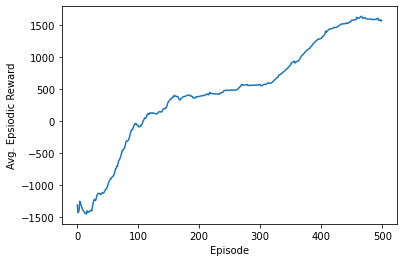

In [34]:
ep_reward_list = []

avg_reward_list = []


for ep in range(total_episodes):

    prev_state = env.reset()
    episodic_reward = 0

    while True:
        

        tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

        action = policy(tf_prev_state, ou_noise)
    
        state, reward, done, info = env.step(action)

        buffer.record((prev_state, action, reward, state))
        episodic_reward += reward

        buffer.learn()
        update_target(target_actor.variables, actor_model.variables, tau)
        update_target(target_critic.variables, critic_model.variables, tau)

        if done:
            break

        prev_state = state

    ep_reward_list.append(episodic_reward)
    avg_reward = np.mean(ep_reward_list[-50:])
    print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
    avg_reward_list.append(avg_reward)


plt.plot(avg_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg. Epsiodic Reward")
plt.show()


In [35]:
no_episodes=[]
for i in range(0,500):
    no_episodes.append(i)

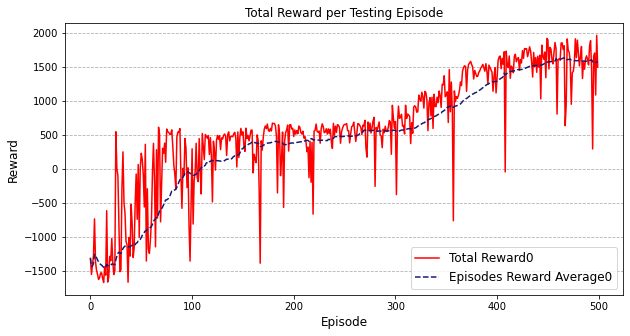

In [36]:
plt.figure(figsize=(10,5))
plt.plot(no_episodes,ep_reward_list, color = 'red',  linestyle = '-', 
        label = 'Total Reward0')

plt.plot(no_episodes, avg_reward_list, color = 'midnightblue',  linestyle = '--', 
        label = 'Episodes Reward Average0')


plt.grid(b = True, which = 'major', axis = 'y', linestyle = '--')
plt.xlabel('Episode', fontsize = 12)
plt.ylabel('Reward',  fontsize = 12)
plt.title('Total Reward per Testing Episode',  fontsize = 12)  
plt.legend(loc = 'lower right', fontsize = 12)    
plt.show()

In [37]:
actor_model.save('Cheetah_actor_std_dev(1.0).h5')

In [38]:
critic_model.save('Cheetah_critic_std_dev(1.0).h5')

In [ ]:
for ep in range(500,700):

    prev_state = env.reset()
    episodic_reward = 0

    while True:
        

        tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

        action = policy(tf_prev_state, ou_noise)
    
        state, reward, done, info = env.step(action)

        buffer.record((prev_state, action, reward, state))
        episodic_reward += reward

        buffer.learn()
        update_target(target_actor.variables, actor_model.variables, tau)
        update_target(target_critic.variables, critic_model.variables, tau)

        if done:
            break

        prev_state = state

    ep_reward_list.append(episodic_reward)
    avg_reward = np.mean(ep_reward_list[-50:])
    print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
    avg_reward_list.append(avg_reward)

Episode * 500 * Avg Reward is ==> 1318.1714488483956
Episode * 501 * Avg Reward is ==> 1320.5825065772174
Episode * 502 * Avg Reward is ==> 1323.1363426276882
Episode * 503 * Avg Reward is ==> 1324.914377464224
Episode * 504 * Avg Reward is ==> 1327.3868113680908
Episode * 505 * Avg Reward is ==> 1330.720752027385
Episode * 506 * Avg Reward is ==> 1316.9254810235311
Episode * 507 * Avg Reward is ==> 1326.0672774441032
Episode * 508 * Avg Reward is ==> 1353.6581605197055
Episode * 509 * Avg Reward is ==> 1348.9286780839875
Episode * 510 * Avg Reward is ==> 1351.3389527383574
Episode * 511 * Avg Reward is ==> 1360.4409699190148
Episode * 512 * Avg Reward is ==> 1362.369846114073
